<a href="https://colab.research.google.com/github/dani16antonio/DeepDream/blob/main/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import (preprocess_input, 
                                                        InceptionV3)
from tensorflow.keras import Model

import numpy as np

In [28]:
class DeepDream:
    def __init__(self, octave_scale=1.3, octave_power_factors=None, 
                 layers=None):
        self.octave_scale=octave_scale
        if octave_power_factors:
            self.octave_power_factors = octave_power_factors
        else:
            self.octave_power_factors = [*range(-2, 3)]
        if layers:
            self.layers = layers
        else:
            self.layers = ['mixed3', 'mixed5']
        self.base_model = InceptionV3(include_top=False)
        outputs = [self.base_model.get_layer(name).output 
                   for name in self.layers]
        self.dreamer_model = Model(self.base_model.input, outputs)
    
    def _calculate_loss(self, image):
        image_batch = tf.expand_dims(image, axis=0)
        activations = self.dreamer_model(image_batch)
        
        if len(activations) == 1:
            activations = [activations]
        
        losses = []
        for activation in activations:
            loss = tf.math.reduce_mean(activation)
            losses.append(loss)
        
        total_loss = tf.math.reduce_sum(losses)
        return total_loss
    
    @tf.function
    def _gradient_ascent(self, image, steps, steps_size, epsilon=1e-8):
        loss = tf.constant(0.0)

        for _ in range(steps):
            with tf.GradientTape() as tape:
                tape.watch(image)
                loss = self._calculate_loss(image)
            
            gradients = tape.gradient(loss, image)
            gradients /= tf.math.reduce_std(gradients) + epsilon
            image = image + gradients * steps_size
            image = tf.clip_by_value(image, -1, 1)

        return loss, image

    def _deprocess(self, image):
        image = 255 * (image +1.) /2.
        image = tf.cast(image, tf.uint8)
        image = np.array(image)
        return image

    def _dream(self, image, steps, step_size):
        image = preprocess_input (image)
        image = tf.convert_to_tensor(image)
        # TODO: test why i use tf.convert_to_tensor and then tf.constant, I think just with tf.constant i enough
        steps_size = tf.convert_to_tensor(step_size)
        steps_size = tf.constant(step_size)
        steps_remaining = steps

        current_step = 0
        while steps_remaining > 0:
            if steps_remaining > 100:
                run_steps = tf.constant(100)
            else:
                run_steps = tf.constant(steps_remaining)
            steps_remaining -= run_steps
            current_step += run_steps
            
            loss, image = self._gradient_ascent(image, run_steps, step_size)
            result = self._deprocess(image)
            return result

    def dream(self, image, steps=100, step_size=0.01):
        image = tf.constant(np.array(image))
        base_shape = tf.shape(image)[:-1]
        base_shape = tf.cast(base_shape, tf.float32)
        
        for factor in self.octave_power_factors:
            new_shape = tf.cast(base_shape * (self.octave_scale ** factor), 
                                tf.int32)
            image = tf.image.resize(image, new_shape).numpy()
            image = self._dream(image, steps, step_size)
        base_shape = tf.cast(base_shape, tf.int32)
        image = tf.image.resize(image, base_shape)
        image = tf.image.convert_image_dtype(image / 255, dtype=tf.uint8)
        return np.array(image)


In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_image(image):
    image = load_img(image)
    image = img_to_array(image)
    return image

In [30]:
image = load_image('me.jpg')

In [32]:
import time
tic = time.time()
dream_image = DeepDream(octave_power_factors=[-6,-3 -1, 0, 3, -2], 
                        layers=['mixed3', 'mixed7', 'mixed9', 'mixed10']).dream(image)
toc = time.time()
print(toc-tic)

144.48291778564453


In [33]:
from PIL import Image
Image.fromarray(dream_image).save('dream_me.jpg')

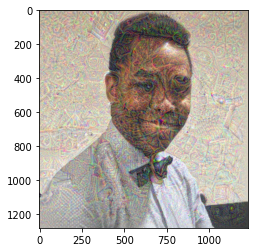

In [34]:
from matplotlib import pyplot as plt
plt.imshow(dream_image)

In [35]:
! nvidia-smi

Fri May 28 03:48:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |  14570MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
InceptionV3().summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
______________________